In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np



res = 32
boxHeight = 1.0
aspect_ratio = 2.0

# A mesh to solve velocity and pressure

VPmesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dPc1"), 
                                   elementRes  = (int(res * aspect_ratio), res), 
                                   minCoord    = (0., 0.), 
                                   maxCoord    = (boxHeight*aspect_ratio, boxHeight))

velocityField    = uw.mesh.MeshVariable( mesh=VPmesh,         nodeDofCount=2 )
pressureField    = uw.mesh.MeshVariable( mesh=VPmesh.subMesh, nodeDofCount=1 )

velocityField.data[:,:] = 0.0
pressureField.data[:] = 0.0


# Boundary conditions - specify:
# Vx on side walls (0) and Vx on top (1)
# Vy on top / bottom (0)

vxWalls = VPmesh.specialSets["MinI_VertexSet"] + \
          VPmesh.specialSets["MaxI_VertexSet"] + \
          VPmesh.specialSets["MaxJ_VertexSet"]

vyWalls = VPmesh.specialSets["MinJ_VertexSet"] + \
          VPmesh.specialSets["MaxJ_VertexSet"]

# We only need to specify the non-zero value of the driving terms because we zeroed everything previously

for index in VPmesh.specialSets["MaxJ_VertexSet"]:
    velocityField.data[index,0] = 1.0

    
# Now register that information

velocityBC = uw.conditions.DirichletCondition( variable = velocityField, 
                                               indexSetsPerDof = (vxWalls, vyWalls) )

    

## Passive tracer "swarm"

In parallel, the management of swarms of particles with a changing distribution
across processors can be quite complicated. 

Underworld does most things behind the scenes but only when we use the built in
functionality to handle and transport particles.

Here is how it works:



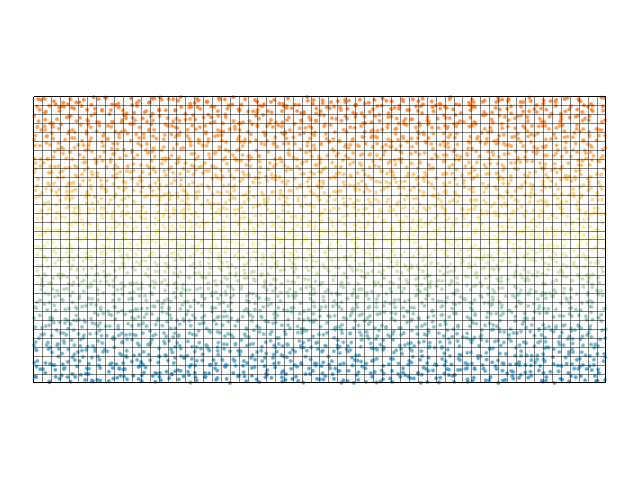

In [2]:
pt_swarm = uw.swarm.Swarm( mesh=VPmesh, particleEscape=True)
pt_swarmLayout = uw.swarm.layouts.PerCellRandomLayout( swarm=pt_swarm, particlesPerCell=2 )
pt_swarm.populate_using_layout( layout=pt_swarmLayout )


# The passive tracer can carry information as well
# We can store the initial y coordinate, for example 

pt_data = pt_swarm.add_variable( dataType="float", count=1)  # scalar value
pt_data.data[:,0] = pt_swarm.particleCoordinates.data[:,1]

fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Mesh(mesh=VPmesh, opacity=0.5))
fig1.append( glucifer.objects.Points(swarm=pt_swarm, pointSize=5.0, opacity=0.95, colourBar=False, fn_colour=pt_data) )
fig1.show()


In [3]:
# The equations are templated already 

stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                               pressureField  = pressureField,
                               conditions     = [velocityBC,],
                               fn_viscosity   = 1.0, 
                               fn_bodyforce   = (0.0,0.0) )

# And a suitable solver package is already attached to it

solver = uw.systems.Solver( stokesPIC )

In [4]:
solver.solve()


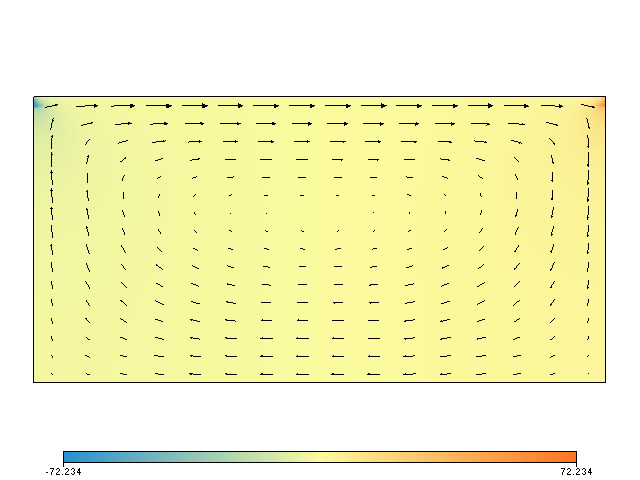

In [5]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.VectorArrows( VPmesh, velocityField, arrowHead=0.2, scaling=0.1 ) )
fig2.append( glucifer.objects.Surface( VPmesh, pressureField ) )
fig2.show()

## Timestep the particles in a steady flow

In [6]:
advector = uw.systems.SwarmAdvector( swarm=pt_swarm, velocityField=velocityField, order=2 )
advector.get_max_dt() # similar to CFL condition, not allowing particles to move too far.


0.0078125

## Solution to the Exercise !

We need to store the particle swarm locations and then make new particles to add to
the swarm. We also need to add a new variable to keep track of the order the points were 
added.

To avoid any problems, we have to delete any local array variables that point directly to the swarm data.





In [7]:
pt_counter = pt_swarm.add_variable(dataType="double", count=1)

# make an actual copy as the underlying array will be scrambled
# when we add new particles.

pt_swarm_seed_locations = pt_swarm.particleCoordinates.data.copy()


In [8]:
time=0.0
timeEnd = 1.0
streak_length = 50
pt_counter.data[:] = streak_length

while time<timeEnd and streak_length:
    
    dt = advector.get_max_dt()
    advector.integrate(dt)
    
    if streak_length > 0:
        streak_length -= 1
        points = pt_swarm.add_particles_with_coordinates(pt_swarm_seed_locations)
        pt_counter.data[points] = streak_length
        pt_data.data[points,0] = pt_swarm.particleCoordinates.data[points,1]
        
     
    time += dt
    


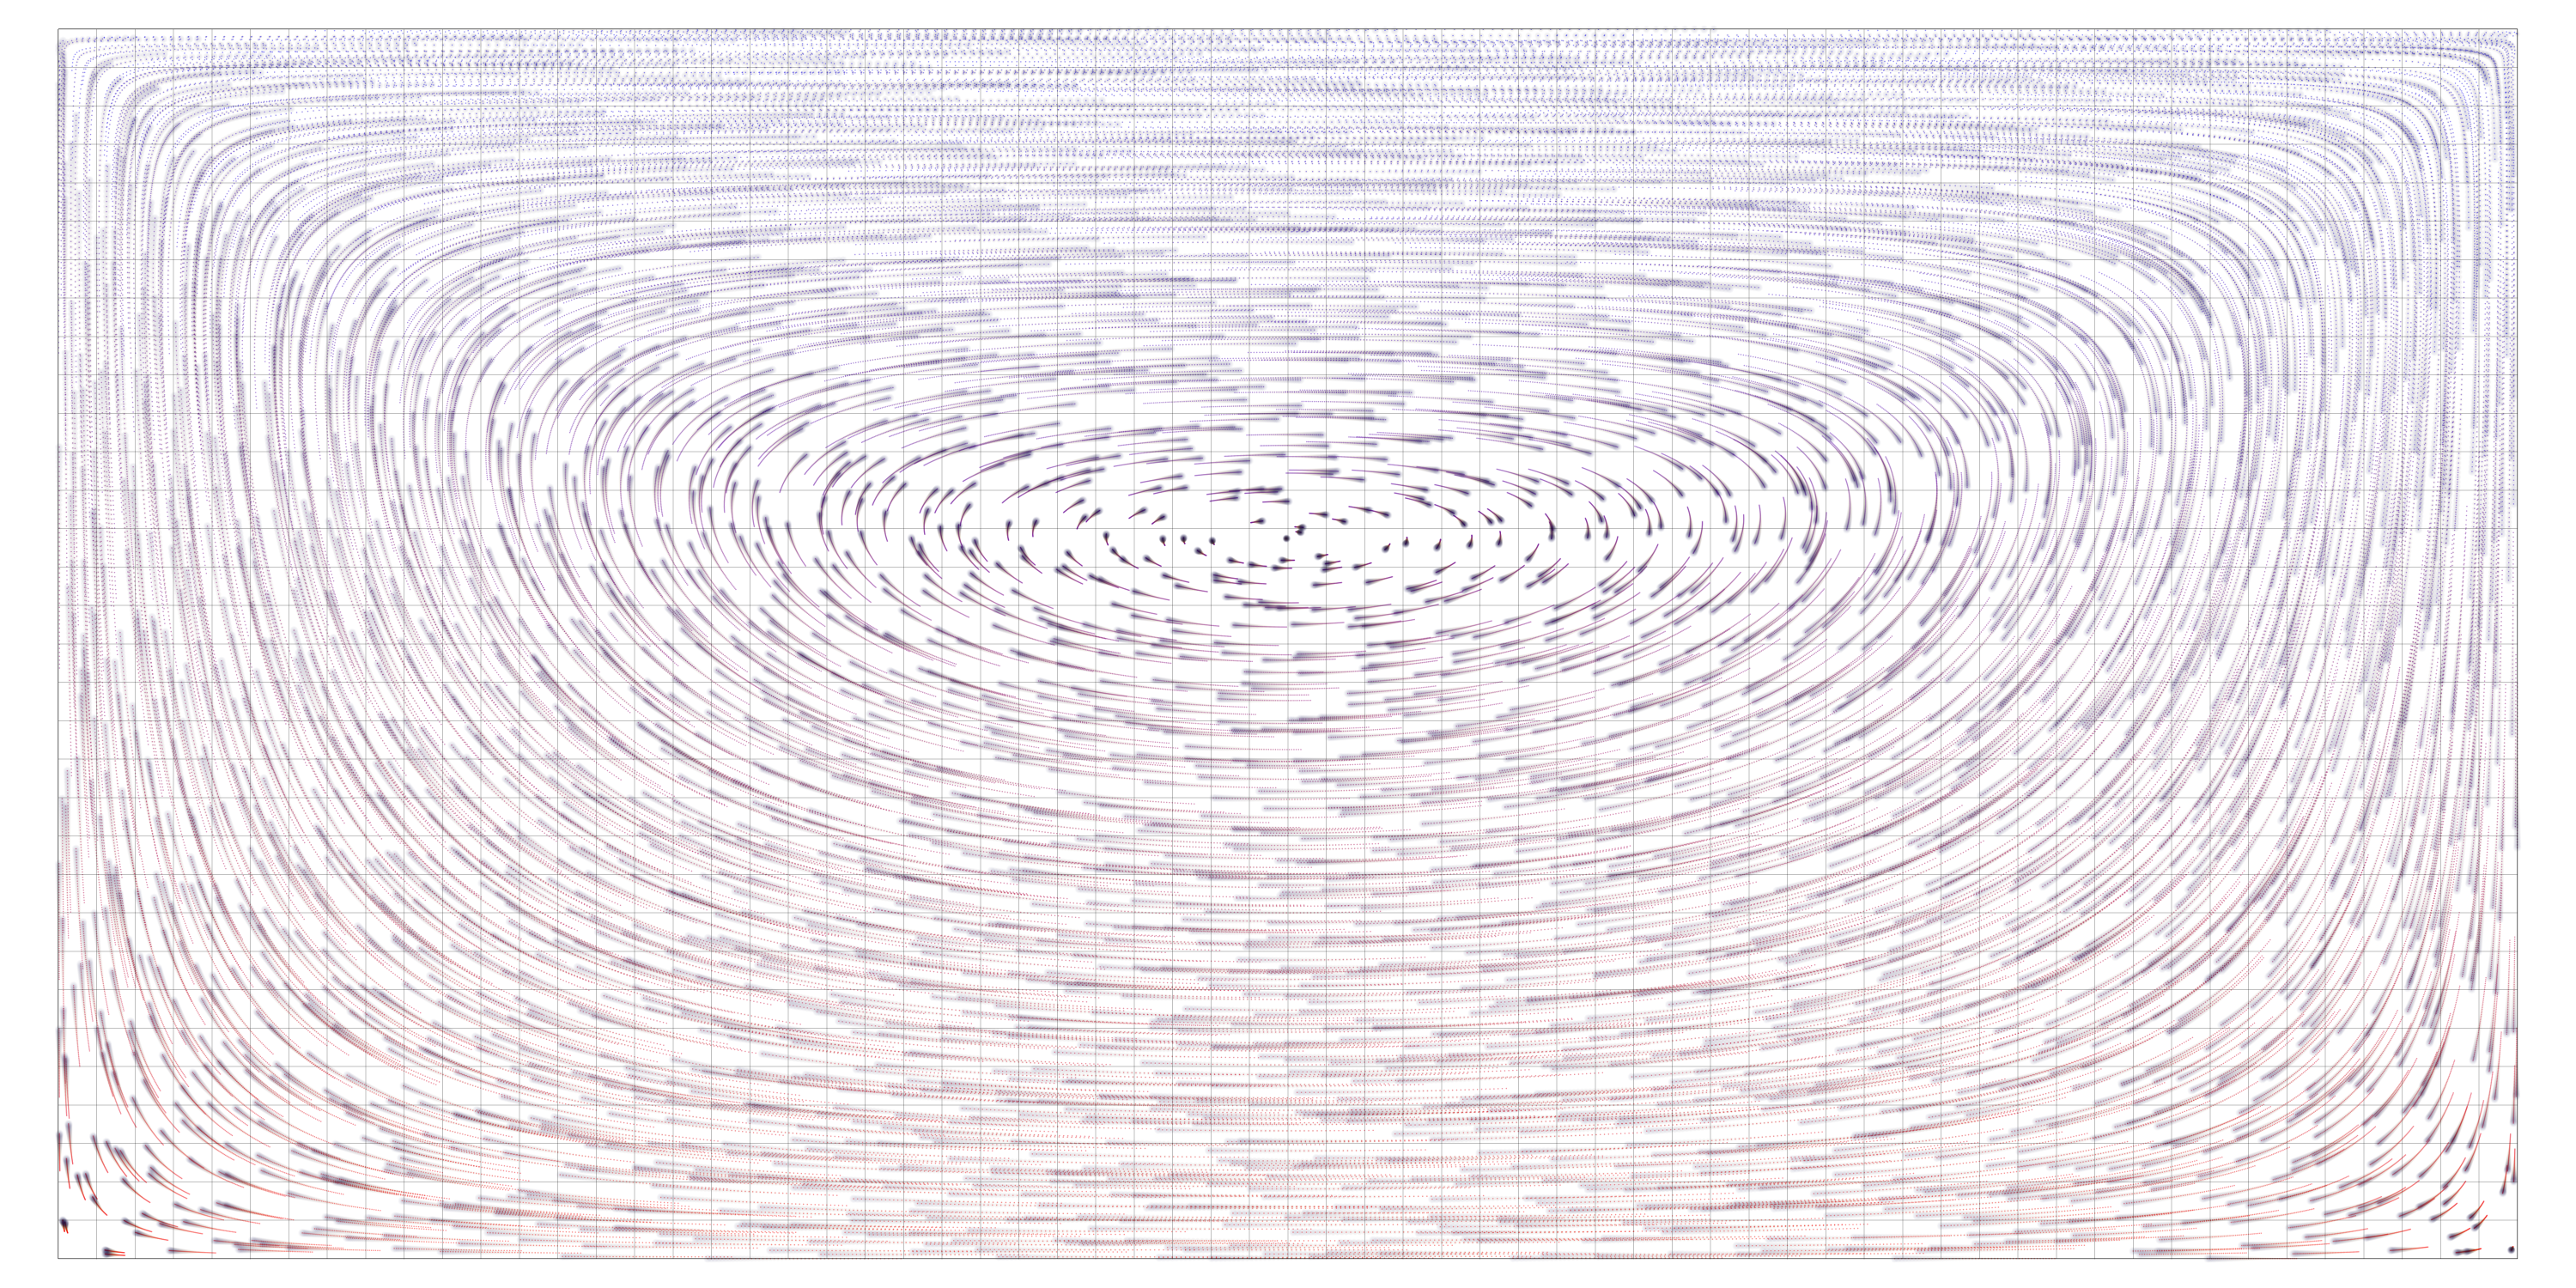

In [18]:
fig1 = glucifer.Figure(figsize=(3000,1500), quality=2)
fig1.append( glucifer.objects.Mesh(mesh=VPmesh, opacity=0.25))
fig1.append( glucifer.objects.Points(swarm=pt_swarm,
                                     colourBar=False, colours="#FFAA00:0.05 #000044:0.1",
                                     fn_colour=pt_counter, fn_size=0.1+0.2*pt_counter) )

fig1.append( glucifer.objects.Points(swarm=pt_swarm, pointSize=2.0, 
                                     colourBar=False, colours="#FF0000:0.5 #0000FF:0.5",
                                     fn_colour=pt_data, fn_size=1.0) )

# fig1.save_image(filename="StreakPlot.png", size=(3000,1500))
fig1.show()